In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
import xgboost as xgb


from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
#Importing dataset 
df = pd.read_csv("/Users/neeraj/Documents/Python/Airbnb/1.Listing_details_1.csv")
df = df[df['price'].notna()]

Remove the irrelevant columns that is used for the scrapping, and only keep the relevant in the data set

In [3]:
bnb_listing = df.drop(["listing_url","scrape_id","last_scraped","last_scraped","source","description","picture_url","host_url","host_thumbnail_url","host_picture_url","longitude","latitude","amenities","calendar_last_scraped","bathrooms","bedrooms","calendar_updated",'license','host_about'], axis=1)

Dividing data columns such that they cover the various different aspect of the Airbnb, like one group can be host related and how does this impact the price, other can be related to future occupancy.

In [4]:
property_unique = ['id','name','neighbourhood_overview']
neighbourhood = ['neighbourhood','neighbourhood_cleansed','neighbourhood_group_cleansed']
host = ["host_id","host_name","host_since","host_location","host_about","host_response_time","host_response_rate","host_acceptance_rate","host_is_superhost","host_neighbourhood","host_listings_count","host_total_listings_count","host_verifications","host_has_profile_pic","host_identity_verified"]
property_details = ["property_type","room_type","accommodates","bathrooms_text","beds"]
price = ["price"]
future_bookings = ['minimum_nights','maximum_nights','minimum_minimum_nights','maximum_minimum_nights','minimum_maximum_nights','maximum_maximum_nights','minimum_nights_avg_ntm','maximum_nights_avg_ntm','has_availability','availability_30','availability_60','availability_90','availability_365']
reviews = ["number_of_reviews","number_of_reviews_ltm","number_of_reviews_l30d","first_review","last_review","review_scores_rating","review_scores_accuracy","review_scores_cleanliness","review_scores_checkin","review_scores_communication","review_scores_location","review_scores_value","reviews_per_month"]
others = ["instant_bookable","calculated_host_listings_count","calculated_host_listings_count_entire_homes","calculated_host_listings_count_private_rooms","calculated_host_listings_count_shared_rooms"]

Basic checks to understand more about if all the listed property are unique or not, and we are not getting any duplicate data

In [5]:
# Convert 'price' column to numeric after removing non-numeric characters
bnb_listing['price'] = pd.to_numeric(bnb_listing['price'].str.replace('[^0-9.]', '', regex=True))

We will do both regression and classification to understand how the both model works

In [6]:
# Define the bin edges for the price categories
bin_edges = [0, 50, 100, 150, 200, 500, 1000, float('inf')]  # Define the edges of the price categories

# Define the labels for the price categories
bin_labels = ['0-50', '51-100', '101-150', '151-200', '201-500','501-1000','1000+']  # Define the labels for the price categories

# Create the 'price_category' column using pd.cut()
bnb_listing['price_category'] = pd.cut(bnb_listing['price'], bins=bin_edges, labels=bin_labels, right=False)

bnb_listing['price_category'].unique()

['151-200', '51-100', '201-500', '101-150', '0-50', '501-1000', '1000+']
Categories (7, object): ['0-50' < '51-100' < '101-150' < '151-200' < '201-500' < '501-1000' < '1000+']

Focusing on property details, doing EDA and building model first only on the property vs. price

In [7]:
bnb_listing['property_type'].unique()

total_property = bnb_listing.groupby('property_type')['property_type'].count()
print(total_property.sort_values(ascending=False))


property_type
Private room in rental unit           684
Entire rental unit                    593
Entire serviced apartment             582
Room in hotel                         205
Entire condo                          199
Private room in condo                 195
Private room in home                  167
Room in boutique hotel                119
Private room in serviced apartment     67
Private room in townhouse              50
Room in aparthotel                     50
Room in hostel                         44
Shared room in hostel                  42
Entire home                            41
Private room in bungalow               31
Shared room in rental unit             26
Private room in bed and breakfast      22
Private room in hostel                 22
Private room in guesthouse             19
Private room                           17
Shared room in bed and breakfast       16
Private room in villa                  16
Shared room in guesthouse              15
Room in serviced apa

In [66]:
import pandas as pd

# List of property types to check for
property_types = ['rental unit', 'serviced apartment', 'condo', 'hotel', 'home', 'boutique hotel',
                  'townhouse', 'aparthotel', 'hostel', 'bungalow', 'bed and breakfast', 'guesthouse', 'villa']

# Initialize the 'other' column
bnb_listing['other'] = 0

# Iterate over the list of property types
for prop_type in property_types:
    # Create a new column for each property type
    bnb_listing[prop_type] = bnb_listing['property_type'].str.lower().str.contains(prop_type.lower()).astype(int)

# Calculate the sum of the property type columns
bnb_listing['sum_of_columns'] = bnb_listing[property_types].sum(axis=1)

# Mark the 'other' column based on the sum of columns
bnb_listing.loc[bnb_listing['sum_of_columns'] == 0, 'other'] = 1

From this we can do feature engineering, and identify the shared bath and number of bath, that we can impute the missing value or nan values.
- Half bath or full bath can be one columns
- Number of baths can  be another
- Private or shared can be another

Our assumbtion is where only bath is written , those are private full baths.

In [71]:
import re

# Convert column to string type
bnb_listing['bathrooms_text'] = bnb_listing['bathrooms_text'].astype(str)

# Iterate over the Series
for lab, row in bnb_listing['bathrooms_text'].items():
    # Use regular expression to extract number of bathrooms from string
    match = re.search(r'(\d+(\.\d+)?)', row)
    if match:
        bnb_listing.loc[lab, 'num_bathrooms'] = float(match.group(1))
    else:
        bnb_listing.loc[lab, 'num_bathrooms'] = 1

    if 'shared' in row:
        bnb_listing.loc[lab, 'Shared_bath'] = 0
    else:
        bnb_listing.loc[lab, 'Shared_bath'] = 1

    if 'half' in row.lower():
        bnb_listing.loc[lab, 'Half_bath'] = 0
    elif 'Half' in row.lower():
        bnb_listing.loc[lab, 'Half_bath'] = 0
    else:
        bnb_listing.loc[lab, 'Half_bath'] = 1


In [73]:
bnb_listing['room_type'].unique()

# Initialize the columns to 0
bnb_listing['Private room'] = 0
bnb_listing['Entire home/apt'] = 0
bnb_listing['Shared room'] = 0

# Iterate over the rows in the 'room_type' column and set the appropriate flags
for lab, row in bnb_listing.iterrows():
    if row['room_type'] in ['Private room', 'Hotel room']:
        bnb_listing.loc[lab, 'Private room'] = 1
    elif row['room_type'] == 'Entire home/apt':
        bnb_listing.loc[lab, 'Entire home/apt'] = 1
    else:
        bnb_listing.loc[lab, 'Shared room'] = 1

In [74]:
# Replacing null beds with mode values
for lab, row in bnb_listing.iterrows():
    if pd.isnull(row['beds']):
        bnb_listing.at[lab, 'beds'] = bnb_listing['beds'].mode()[0]


In [110]:
X = ['rental unit','serviced apartment','condo','hotel','home','boutique hotel','townhouse','aparthotel','hostel','bungalow','bed and breakfast','guesthouse','villa','other','num_bathrooms','Shared_bath','Half_bath','Private room','Entire home/apt','Shared room','beds','accommodates']
Y = ['price']

In [111]:
x_final = bnb_listing[X]
y_final = bnb_listing[Y]

In [113]:
#Splitting data into train and test
x_train, x_test, y_train, y_test = train_test_split(x_final ,bnb_listing[Y], test_size=0.2, random_state=21)

In [115]:
models = {
    'Decision Tree Regression': DecisionTreeRegressor(),
    'Random Forest Regression': RandomForestRegressor(),
    'Gradient Boosting Regression': GradientBoostingRegressor(),
    'AdaBoost Regression': AdaBoostRegressor(),
    'xgboost': xgb.XGBRegressor()
}

In [122]:
from sklearn.metrics import mean_absolute_error, r2_score

# Assuming `models` is a dictionary of your regression models
model_mae_train = {}
model_mae_test = {}
model_r2_train = {}
model_r2_test = {}

for label, regressor in models.items():
    regressor.fit(x_train, y_train)
    predictions_train = regressor.predict(x_train)
    predictions_test = regressor.predict(x_test)
    
    mae_train = mean_absolute_error(y_train, predictions_train)
    mae_test = mean_absolute_error(y_test, predictions_test)
    r2_train = r2_score(y_train, predictions_train)
    r2_test = r2_score(y_test, predictions_test)
    
    model_mae_train[label] = mae_train
    model_mae_test[label] = mae_test
    model_r2_train[label] = r2_train
    model_r2_test[label] = r2_test

# Print MAE and R² for training data
print("Training Data________________________________")
for model in model_mae_train:
    print(f"{model}: MAE={model_mae_train[model]}, R²={model_r2_train[model]}")

# Print MAE and R² for test data
print("\nTest Data________________________________")
for model in model_mae_test:
    print(f"{model}: MAE={model_mae_test[model]}, R²={model_r2_test[model]}")


/Users/neeraj/Documents/.conda/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/neeraj/Documents/.conda/lib/python3.12/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Users/neeraj/Documents/.conda/lib/python3.12/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training Data________________________________
Decision Tree Regression: MAE=120.78590606325895, R²=0.3171802470298455
Random Forest Regression: MAE=132.57841236340204, R²=0.2912013066803967
Gradient Boosting Regression: MAE=147.42405808895165, R²=0.17211800672373156
AdaBoost Regression: MAE=272.27335450012805, R²=-0.10615683075081117
xgboost: MAE=125.32612597973687, R²=0.3135977294670279

Test Data________________________________
Decision Tree Regression: MAE=153.1147928644074, R²=0.06572019489913916
Random Forest Regression: MAE=149.72163935702457, R²=0.20107318298871069
Gradient Boosting Regression: MAE=151.5572057862772, R²=0.16127056354420788
AdaBoost Regression: MAE=267.2745071436025, R²=-0.051942804875134474
xgboost: MAE=147.25579185600395, R²=0.16412401314747194


Decision tree regression is giving the best result, we will use it to check out the specific issue

We will deep dive into DecisionTree and Randomforest to understand the importance of the each parameter, at the same time we need to understand if have enough sample size 

In [123]:
model_DT = DecisionTreeRegressor()
model_Regression = RandomForestRegressor()

In [125]:
model_DT.fit(x_train,y_train)
dt_train_predict = model_DT.predict(x_train)
dt_test_predict = model_DT.predict(x_test)

mae_dt_train = mean_absolute_error(y_train,dt_train_predict)
mae_dt_test = mean_absolute_error(y_test,dt_test_predict)


print(mae_dt_test)
print(mae_dt_train)

152.7596073217219
120.78590606325895


               Feature  Importance
20                beds    0.191262
18     Entire home/apt    0.149051
21        accommodates    0.141170
14       num_bathrooms    0.136111
0          rental unit    0.102892
3                hotel    0.057611
19         Shared room    0.044376
2                condo    0.038838
15         Shared_bath    0.034932
4                 home    0.034580
1   serviced apartment    0.028490
5       boutique hotel    0.018914
13               other    0.017278
16           Half_bath    0.001194
8               hostel    0.000821
10   bed and breakfast    0.000789
6            townhouse    0.000733
9             bungalow    0.000591
11          guesthouse    0.000207
7           aparthotel    0.000097
17        Private room    0.000050
12               villa    0.000015


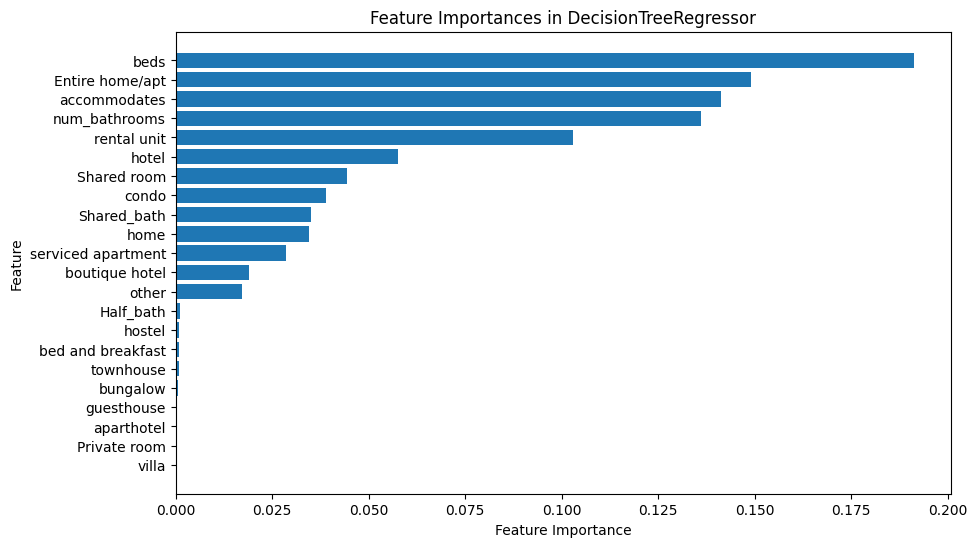

In [127]:
feature_importance = model_DT.feature_importances_

# Create a DataFrame to view feature importances
features_df = pd.DataFrame({
    'Feature': x_train.columns,
    'Importance': feature_importance
})

# Sort features by importance
features_df = features_df.sort_values(by='Importance', ascending=False)

print(features_df)

# Optionally, visualize the feature importances
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(features_df['Feature'], features_df['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importances in DecisionTreeRegressor')
plt.gca().invert_yaxis()  # To display the highest importance at the top
plt.show()

In [3]:
import os 
wd = os.getcwd() #Store the name of the current directory
os.listdir(wd) #Outputs the contents of the directory in a list to the shell

['EDA.ipynb',
 '.DS_Store',
 '6.reviews.csv',
 'predictions.csv',
 '3.Listing_details_3.csv',
 '1.Listing_details_1.csv',
 '4.reviews 2.csv',
 'old.csv',
 'Modeling_V0.1.ipynb',
 'venv',
 'BnB.py',
 'Airbnb Data Dictionary.xlsx',
 '.vscode',
 '7.neighbourhoods.csv']